<a href="https://colab.research.google.com/github/hudsonmendes/uolondon-cm3070-fp/blob/objective_7_r1/dev/mlops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Code & Data

In this section, we load the code and the data locally, so that we can utilise  the `hlm12erc` package and use the ml pipelines as they have been designed.

The code files are copied from the following folder, and it's copied to the root directory of the present runtime.
> `/content/drive/MyDrive/Code/github/universityoflondon/cm3070-fp/*`

The following .zip file contains the data compressed, and we decompress it into the `./data` folder:
> `/content/drive/MyDrive/Datasets/meld-transformed.zip`

In [ ]:
from google.colab import drive

drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os

if not os.path.exists("./pyproject.toml"):
    print("Source Code: overriding, it may take a while...")
    !rm -rf ./src
    !rm -rf ./tests
    !rm -rf ./configs
    !cp -R /content/drive/MyDrive/Code/github/universityoflondon/cm3070-fp_20230914_0943/* .
    print("Source Code: overwritten!")

if not os.path.exists("./data/d-0-seq-0.png"):
    print("Data: overriding, it may take a while...")
    !rm -rf ./data/
    !unzip -qq -j "/content/drive/MyDrive/Datasets/meld-transformed.zip" -d "./data/"
    print("Data: overwritten!")

Source Code: overriding, it may take a while...
Source Code: overwritten!
Data: overriding, it may take a while...
Data: overwritten!


In [ ]:
!rm -rf ./data/*.csv
!unzip -j "/content/drive/MyDrive/Datasets/meld-transformerd-csvs.zip" -d "./data/"

Archive:  /content/drive/MyDrive/Datasets/meld-transformerd-csvs.zip
  inflating: ./data/sample.csv       
  inflating: ./data/test.csv         
  inflating: ./data/valid.csv        
  inflating: ./data/train.csv        


# Environment

In this section of our project, we delve into the technical groundwork, outlining the structuring of our dependencies, initializing key system configurations and paths that will be leveraged throughout the ensuing stages.

At the heart of this setup is the `pyproject.toml` file, which lists our project's dependencies and facilitates the seamless installation of our custom-built **`hlm12erc`** library. By using the `-e` option for pip, we unlock dynamic editing capabilities for the library's codebase without requiring repeated reinstallation.

To optimise our system, we've crafted different sets of dependencies for each critical task, including `etl`, `eda`, `modelling`, `training`, and `serving`, allowing us to targetting installations to different environments where certain packages aren't needed.

## Dependencies

In [ ]:
!cat ./pyproject.toml

[build-system]
requires = ["setuptools", "wheel"]

[project]
name = "hlm12erc"
version = "0.0.1"
authors = [{ name = "Hudson Mendes", email = "hlm12@student.london.ac.uk" }]
description = "Final Project from University of London"
readme = "README.md"
license = { file = "LICENSE" }
urls = { homepage = "https://github.com/hudsonmendes/cm3070-fp" }
keywords = ["university-of-london"]
dependencies = [
    "torch >= 2.0.1",
    "torchtext >= 0.15.2",
    "torchvision >= 0.15.2",
    "transformers >= 4.30.2",
    "Pillow >= 10.0.0",
    "scikit-learn >= 1.3.0",
    "opencv-python>=4.8.0.76",
]

[project.optional-dependencies]
dev = ["pre-commit>=3.3.3", "black[jupyter]>=23.7.0", "isort>=5.12.0"]
test = ["pytest>=7.4.0", "hypothesis>=6.84.2"]
etl = [
    "kaggle>=1.5.13",
    "tqdm>=4.65.0",
    "pandas>=2.0.1",
    "google-cloud-storage>=2.10.0",
    "moviepy>=1.0.3",
]
eda = [
    "gensim",
    "tensorflow",
    "tensorflow-hub",
    "torch",
    "transformers",
    "librosa",
    "umap-lea

In [ ]:
%pip install -e '.[training]'

Obtaining file:///content
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 120.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25

**Attention:** for the first time you run this notebook in a runtime, you you must restart your kernel at this point, because the dependencies you installed above bring in newer versions of libraries like `pandas`,etc.

In [ ]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
%load_ext autoreload
%autoreload 2

## Logging

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

## Paths & Locations

In [ ]:
import pathlib

# now that the chdir is set to the parent directory of the notebook,
# we can work as if we were running in the root directory of the repository
dir_home = pathlib.Path("./")
dir_data = dir_home / "data"
dir_target = dir_home / "target"
dir_configs = dir_home / "configs"

## GPUs for Training

For this MLOps Pipeline, we use GPUs to accelerate Machine Learning Training.

TPUs have been tried out, but the limitations and constraints related to the TPU architecture caused it to be inviable to the available timeframe of the project. [The main blocker has been reported](https://discuss.pytorch.org/t/error-when-attempting-to-access-xla-tensor-shape/186214) to the PyTorch XLA team before the decision to pivot into GPUs was made.

In [ ]:
# In order to try training using TPUs, uncomment the code below
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

# The following code sets the `device` to one of the GPUs
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
device

device(type='cuda', index=0)

# Defining the Problem

Emotion Recognition in Conversations (ERC) refers to the process of recognising and analysing emotions in interactive dialogues. It presents a unique set of challenges given the fact that the same words or phrases could convey different emotions depending on the context and flow of the conversation. This task is further complicated when applied in non-dyadic settings, where multiple participants engage in a dialogue. This makes ERC a complex problem within the realm of machine learning and artificial intelligence, where context modelling and emotional shifts among interlocutors are difficult to address accurately.

Despite its complexity, ERC has garnered significant interest owing to its vast applications in opinion mining over social media threads, chat history, and other online platforms. The ability to accurately discern emotions in conversations can have profound implications for various industries, making any advancements in this field potentially groundbreaking. However, given the sparsity of the solution space and the high variability in model architecture, ERC remains a largely unexplored area with many potential paths for future research and experimentation.

## Multi-Party Setting Challenge

Multi-party conversations present an inherent set of challenges when it comes to emotion recognition (ERC). In a dialogue involving multiple participants, the context, conversation flow, and emotional shifts become considerably more intricate to decipher. The utterances in multi-party dialogues can express a wide range of emotions based on the context, making the task of accurate emotion recognition more arduous. This problem of contextual modelling and accounting for emotion shifts among multiple interlocutors remains a significant challenge in ERC. Additionally, the complex dynamics of multi-party conversations and the interdependence of individual emotional states further complicate the task.

The multi-modality of ERC data also poses another layer of challenge in multi-party settings. As emotions can only be detected through human actions such as textual utterances, visual gestures, and acoustic signals in the absence of physiological indications, the need for effectively dealing with multi-modal data becomes crucial. While some models focus on exploring this multi-modality, others resort to using a single modality, usually textual, thereby ignoring valuable insights that could be gleaned from other modalities. Consequently, the architectural variations in the existing models, coupled with the largely unexplored solution space, underscore the daunting challenges of emotion recognition in multi-party settings.

## Multi-modality Challenge

The multifaceted challenge of Emotion Recognition in Conversations (ERC) is magnified by the multi-modal nature of the data involved. ERC data typically consists of multiple modalities, such as textual utterances, visual cues, and acoustic signals. Accurately detecting emotions from these varied sources is complex, as they can individually or collectively contribute to the overall emotional context. This complexity is amplified by the high-dimensionality of the data, particularly in video and audio modalities. This high-dimensional data is both difficult to investigate and expensive to compute, posing significant challenges in data handling, processing, and analysis.

Furthermore, the computation and training of multi-modal models are exceptionally resource-intensive. Each modality may require distinct computational approaches and algorithms for processing and analyzing the data, increasing the overall computational load. Training such models also necessitates substantial computational power and time, often leading to increased costs and resource allocation. These factors, combined with the diverse architectures proposed to model ERC, contribute to the intricate and computationally demanding nature of emotion recognition. Despite the high costs and complexity, the vast potential applications of accurate ERC underscore the importance of ongoing research in this challenging, yet highly rewarding, field of machine learning.

# Assembling the Dataset

This notebook works on the **Loaded** data (already transformed through the ETL process), and unzipped in the top section of the notebook.

Here is more information about the ETL process used from the `dev/modelling.ipynb`:
> This section of the document focuses on assembling the final dataset that will be used for training and evaluating machine learning models. This involves performing ETL (Extract, Transform, Load) operations on the raw MELD data[1, 2] to prepare it for modelling. ETL is a process used to extract data from various sources, transform it into a format that is suitable for analysis, and load it into a target database or data warehouse. In this section, the raw data is extracted from various sources, transformed into a format that can be used for modelling, and loaded into a Pandas DataFrame.
>
> Here the final dataset is assembled by combining the preprocessed text, audio, and visual features for each example. The `hlm12erc` library is used to load the preprocessed features for each example and combine them into a single DataFrame. This library was created specifically for this project to simplify the notebook code by abstracting the ETL complexity into a simple, well-tested library that could be reused and scheduled if needed. The library was designed with full unit-test coverage to ensure that the data is loaded and combined correctly. The resulting DataFrame contains the preprocessed features for each example, as well as the corresponding label, which will be used for training and evaluating the machine learning models.

In [ ]:
from hlm12erc.training import MeldDataset

ds_sample = MeldDataset(dir_data / f"sample.csv")
ds_train = MeldDataset(dir_data / f"train.csv")
ds_valid = MeldDataset(dir_data / f"valid.csv")
ds_test = MeldDataset(dir_data / f"test.csv")

In [ ]:
ds_train.df

,Unnamed: 0,dialogue,sequence,speaker,x_text,x_visual,x_audio,label
0,0,0,0,Chandler,also I was the point person on my companys tr...,d-0-seq-0.png,d-0-seq-0.wav,neutral
1,1,0,1,The Interviewer,You mustve had your hands full.,d-0-seq-1.png,d-0-seq-1.wav,neutral
2,2,0,2,Chandler,That I did. That I did.,d-0-seq-2.png,d-0-seq-2.wav,neutral
3,3,0,3,The Interviewer,So lets talk a little bit about your duties.,d-0-seq-3.png,d-0-seq-3.wav,neutral
4,4,0,4,Chandler,My duties? All right.,d-0-seq-4.png,d-0-seq-4.wav,surprise
...,...,...,...,...,...,...,...,...
9984,9984,1038,13,Chandler,You or me?,d-1038-seq-13.png,d-1038-seq-13.wav,neutral
9985,9985,1038,14,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",d-1038-seq-14.png,d-1038-seq-14.wav,neutral
9986,9986,1038,15,Joey,"You guys are messing with me, right?",d-1038-seq-15.png,d-1038-seq-15.wav,surprise
9987,9987,1038,16,All,Yeah.,d-1038-seq-16.png,d-1038-seq-16.wav,neutral


Speaker,Text,Image,Audio,Emotion
Phoebe,"She moved in with a guy who was secretly married to her and he said he didnt love her, but he really did, and it just blew up!",,,anger
Rachel,"Ross, what's the matter?",,,anger
Monica,"You wanna go right now? 'Cause I'll take you right now, buddy! You wanna go?",,,anger
Rachel,"Oh my God!! Ohh, that is it! Im leaving! You are just a horrible person!",,,disgust
Monica,"I know, hes too charming, but if you two start going out, then its just gonna make it so much harder for me to hate him.",,,disgust
Phoebe,Youre disgusting!,,,disgust
Joey,"I wake up this morning, the strippers gone and the ring is gone!",,,fear
Ross,Okay?,,,fear
Chandler,I want her to think I might be in a restaurant.. y'know?,,,fear
Chandler,Here it is! Here it is!,,,joy

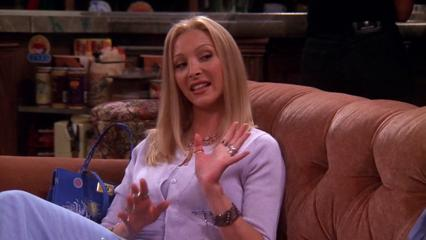
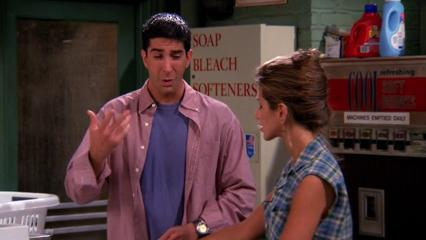
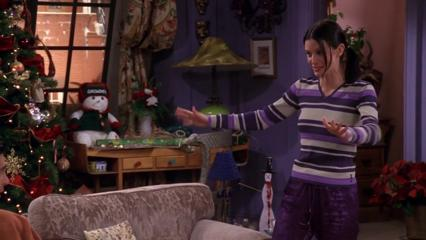
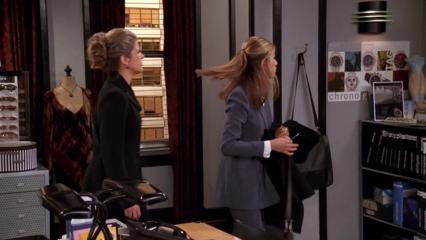
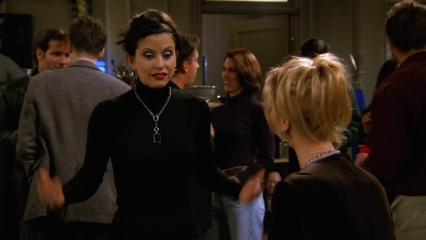
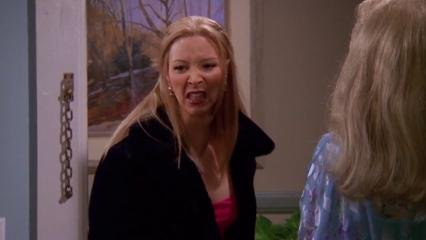
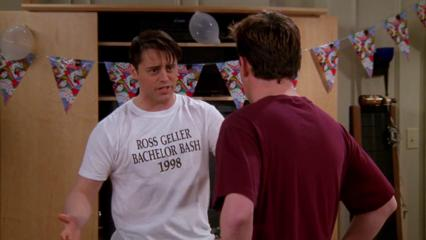
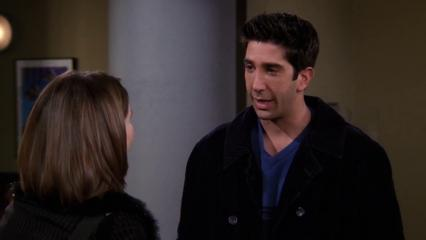
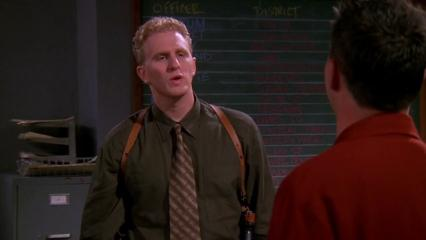
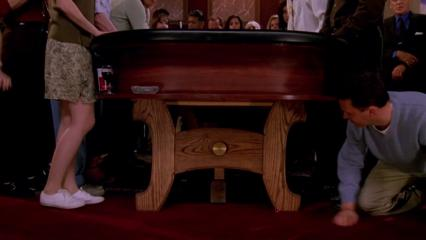
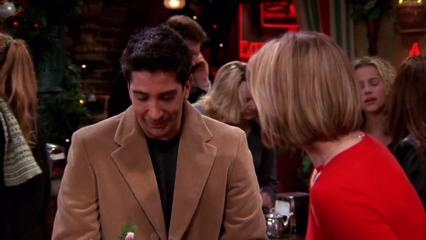
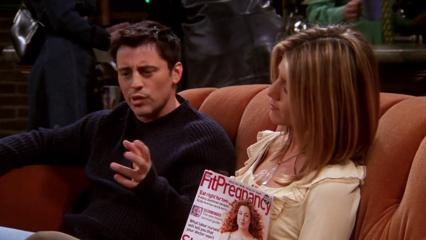
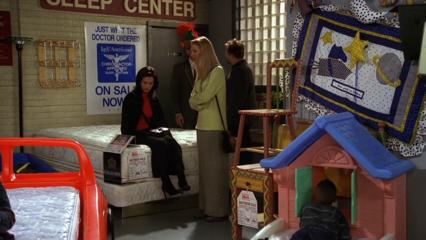
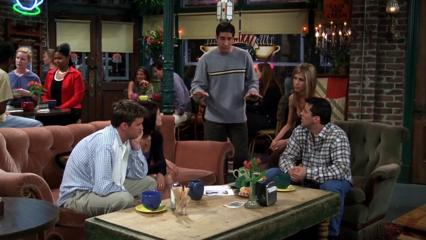
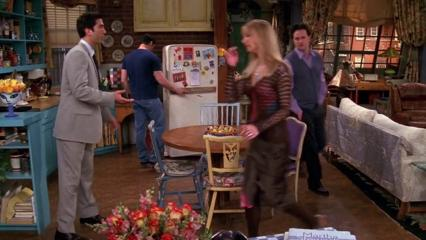
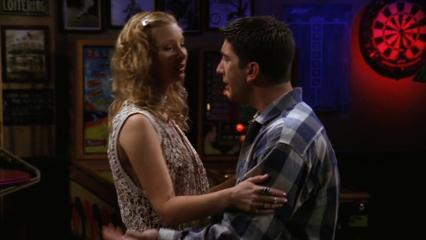
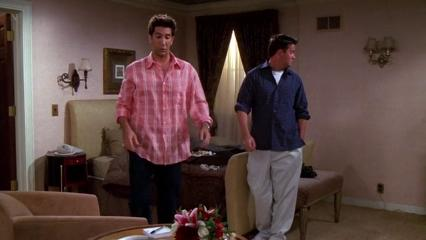
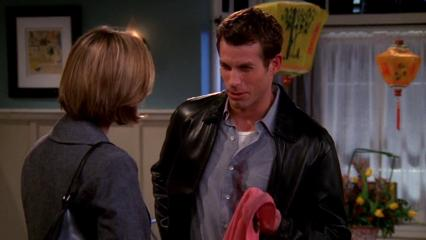
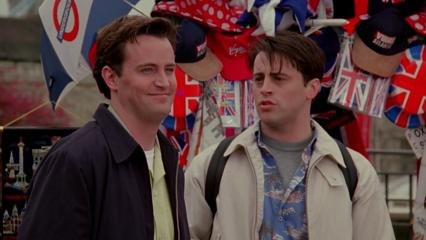
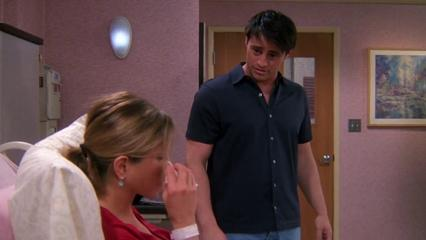
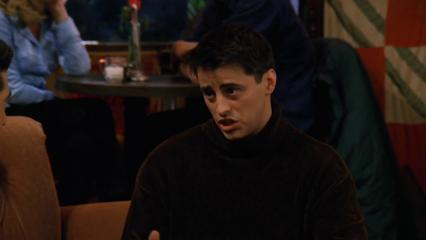

In [ ]:
import os
import io
import base64
from IPython.display import display, HTML
from PIL import Image

df_sample = ds_train.df.groupby(["label"], group_keys=False).apply(lambda x: x.sample(min(len(x), 3)))
df_sample = df_sample.sort_values(["label"])

table_rows = []
for i, row in df_sample.iterrows():
    speaker_cell = f'<td>{row["speaker"]}</td>'
    text_cell = f'<td>{row["x_text"]}</td>'
    image_path = dir_data / row["x_visual"]
    with Image.open(image_path) as img:
        width, height = img.size
        crop_top = height // 2 - height // 10
        crop_bottom = height // 2 + height // 10
        img_cropped = img.crop((0, crop_top, width, crop_bottom))
        buffer = io.BytesIO()
        img_cropped.save(buffer, format="JPEG")
        image_data = base64.b64encode(buffer.getvalue()).decode()
    image_cell = f'<td><img src="data:image/jpeg;base64,{image_data}" width="100"></td>'
    audio_cell = f'<td><audio controls src="{os.path.join("data/", row["x_audio"])}" /></td>'
    label_cell = f'<td>{row["label"]}</td>'
    table_rows.append(f"<tr>{speaker_cell}{text_cell}{image_cell}{audio_cell}{label_cell}</tr>")

table_html = (
    "<table><tr><th>Speaker</th><th>Text</th><th>Image</th><th>Audio</th><th>Emotion</th></tr>"
    + "".join(table_rows)
    + "</table>"
)
display(HTML(table_html))

# Choosing the Metric of Success

The chosen metric of success for the **HLM12ERC** project, opposed to what was originally outlined in the design document, is **`F1 (Weighted)`**, in the form it's calculated by the `scikit-learn` library[3].

The reason for the choice is that, as exposed by the **Exploratory Data Analysis**, the **MELD Dataset** is considerably class-imbalanced. Blind assumption of the `neutral` class would result in $48%$ accuracy, which could erroneously be assumed to have statistical power (better than random), which would be roughly $1/7$ or $14\%$ accuracy.

This choice clearly aligns with the principles described by Francois Chollet in "Choosing the Metric of Success"[4], where the selection of a suitable metric is vital for effectively guiding the optimization of machine learning models and for a fair comparative analysis of different methods.

In [ ]:
import inspect
from hlm12erc.training import ERCEvaluator
from IPython.display import Code

class_code = inspect.getsource(ERCEvaluator)
Code(class_code, language="python")

class ERCEvaluator:
    model: ERCModel
    label_encoder: ERCLabelEncoder
    data_collator: ERCDataCollator

    def __init__(self, model: ERCModel) -> None:
        self.model = model
        self.label_encoder = model.label_encoder
        self.data_collator = ERCDataCollator(label_encoder=model.label_encoder, config=model.config)

    def evaluate(
        self,
        dataset: MeldDataset,
        device: torch.device | None = None,
        batch_size: int = 4,
        output_dict: bool = False,
    ) -> Dict[str, Any] | None:
        """
        Evaluates the model on the given dataset.

        :param dataset: The dataset to evaluate on, usually the test split.
        :param device: The device to run the data collation on
        :param batch_size: The size of the batches that will be run against the model
        :param output_dict: Whether to return the classification report dictionary
        :return: The classification report dictionary, unless print_only=True
        """
        if device is not None:
            self.model.to(device)

        emotions = self.label_encoder.classes
        labels, preds = None, None
        with torch.no_grad():
            labels, preds = self._collect_labels_and_preds(dataset, device, batch_size)

        return self._report_on_results(emotions, labels, preds, output_dict)

    def _collect_labels_and_preds(self, dataset, device, batch_size) -> Tuple[List[List[int]], List[List[int]]]:
        """
        Collects the one hot encodings of the true labels and the prediction softmax distributions,
        stack them and run an argmax (on axis 1) to get the integers representing the labels.

        :param dataset: The dataset to evaluate on, usually the test split.
        :param device: The device to run the data collation on
        :param batch_size: The size of the batches that will be run against the model
        :return: A tuple of two lists, the first being the true labels and the second being the predicted labels
        """
        y_true, y_pred = [], []
        for start in trange(0, len(dataset), batch_size, desc="evaluating"):
            end = start + batch_size
            batch_records = dataset[start:end]
            batch_collated = self.data_collator(batch_records, device=device)
            y_true.extend(batch_collated["y_true"])
            y_pred.extend(self.model(**batch_collated).labels)
        labels = torch.stack(y_true, dim=0).argmax(dim=1).tolist()
        preds = torch.stack(y_pred, dim=0).argmax(dim=1).tolist()
        return labels, preds

    def _report_on_results(
        self,
        emotions: List[str],
        labels: List[List[int]],
        preds: List[List[int]],
        output_dict: bool,
    ) -> Dict[str, Any] | None:
        """
        Prints the classification report and returns the report dictionary.

        :param emotions: The list of emotions
        :param labels: The true labels
        :param preds: The predicted labels
        :param output_dict: Whether to return the classification report dictionary
        :return: The classification report dictionary
        """
        print(classification_report(y_true=labels, y_pred=preds, target_names=emotions))
        if output_dict:
            return classification_report(y_true=labels, y_pred=preds, target_names=emotions, output_dict=True)

In [ ]:
import inspect
from hlm12erc.training import ERCMetricCalculator
from IPython.display import Code

class_code = inspect.getsource(ERCMetricCalculator)
Code(class_code, language="python")

class ERCMetricCalculator:
    """
    Responsible for calculating the metrics for an ERC prediction against
    the ground truth, including the loss if a loss function is provided.
    """

    loss_fn: Optional[ERCLoss]

    def __init__(self, config: ERCConfig) -> None:
        """
        Contructs a new ERCMetricCalculator.

        :param classifier_loss_fn: The name of the loss function to use for the classifier.
        """
        self.loss_fn = None
        if config is not None and config.classifier_loss_fn is not None:
            self.loss_fn = ERCLoss.resolve_type_from(config.classifier_loss_fn)(config)

    def __call__(self, eval_pred: EvalPrediction) -> Dict[str, Any]:
        """
        Calculates the `acc`, `f1_weighted`, `p_weighted`, `r_weighted`.
        It also produces the `loss` in case a `self.loss_fn` is provided.

        :param eval_pred: The evaluation prediction to calculate the metrics for.
        :return: A dictionary containing the metrics.
        """
        pred, labels = self._extract_pred_loss(eval_pred)
        return self._build_output(
            loss=self._determine_loss(pred=pred, labels=labels),
            y_true=labels.argmax(dim=1).cpu(),
            y_pred=pred.argmax(dim=1).cpu(),
        )

    def _extract_pred_loss(self, eval_pred) -> Tuple[torch.Tensor, torch.Tensor]:
        pred = eval_pred.predictions
        labels = eval_pred.label_ids
        pred = pred[0] if isinstance(pred, tuple) else pred
        pred = torch.from_numpy(pred) if isinstance(pred, np.ndarray) else pred
        labels = torch.from_numpy(labels) if isinstance(labels, np.ndarray) else labels
        return pred, labels

    @torch.no_grad()
    def _determine_loss(self, pred: torch.Tensor, labels: torch.Tensor):
        return self.loss_fn(y_pred=pred, y_true=labels) if self.loss_fn is not None else None

    def _build_output(self, loss: Union[float, torch.Tensor], y_true: torch.Tensor, y_pred: torch.Tensor):
        output = {}
        if loss:
            output["loss"] = loss.item() if isinstance(loss, torch.Tensor) else loss
        output["acc"] = accuracy_score(y_true, y_pred)
        output["f1_weighted"] = f1_score(y_true, y_pred, average="weighted")
        return output

# Deciding on the Evaluation Protocol

The evaluation protocol for the **HLM12ERC** project adopts the **`Hold Out Test-set`** approach, a decision influenced by the structure of the MELD Dataset and the constraints imposed by its size and multimodal nature. This dataset comes pre-divided into three splits: `train`, `dev`, and `test`, which directly supports the implementation of the Hold Out approach.

The choice of this protocol is further justified due to the impracticability of using methods like K-Fold Cross Validation, stemming from the significant computational demands of the MELD dataset. In addition, the Hold Out Test-set approach serves as the evaluation standard for both individual components (Objectives 1 to 6) and the final model (Objective 7), ensuring consistent assessment throughout the development process.


In [ ]:
import pandas as pd

df_stats = pd.DataFrame.from_dict(
    dict(train=len(ds_train), valid=len(ds_valid), test=len(ds_test)), orient="index", columns=["count"]
)

df_stats["percentage"] = df_stats.apply(lambda row: f'{round(100. * row["count"] / df_stats["count"].sum())}%', axis=1)

df_stats

,count,percentage
train,9989,73%
valid,1109,8%
test,2610,19%


# Preparing your Data

The data preparation process in this code involves three main stages: (a) ETL (Extract, Transform, Load), (b) DataSet Loading, and (c) Data Collation for model training.

* **ETL:** This stage simplifies the dataset by extracting the data from a Kaggle source, transforming it into a 1st Normal Form (1NF) CSV table format, and loading it into a destination folder or Google Cloud Storage bucket. The ETL process makes the data easier to consume by the training process. The logic can be found in the `hlm12erc.etl` module, and it can also be run with a command-line instruction, and orchestrated through the `hlm12erc.etl.ETL` class.

* **DataSet Loading:** This stage wraps the data using PyTorch Data Utility Classes to shape it appropriately for consumption by the model trainer. This step ensures that the data is organized and can be efficiently fed into the training process. The dataset class is defined at `hlm12erc.training.MeldDataset`.

* **Data Collation:** The Data Collator is responsible for creating batches of data suitable for model training and evaluation. It takes a list of MeldRecord instances and collates the data into a dictionary format with keys like `x_text`, `x_visual`, `x_audio`, and `y_true`. The collation involves converting text, visual, and audio data into appropriate formats and encoding the labels using ERCLabelEncoder, making the data ready for consumption by the PyTorch model's "forward" method during both training and inference. The collator class is defined at `hlm12erc.training.ERCDataCollator`, and can be observed below.

In [ ]:
import inspect
from hlm12erc.training import MeldDataset
from IPython.display import Code

class_code = inspect.getsource(MeldDataset)
Code(class_code, language="python")

class MeldDataset(Dataset):
    """
    Using a dataframe to the dataset .csv file, this class allows access to
    the data in the high level form of a `MeldRecord` object, that already
    carries the visual features (PIL.Image) and audio features (wave.Wave).

    Example:
        >>> df = pd.read_csv("data/meld/train.csv")
        >>> dataset = MeldDataset(df)
        >>> record = dataset[0]
    """

    filepath: pathlib.Path
    filedir: pathlib.Path
    df: pd.DataFrame
    classes_: List[str]
    preprocessors_text: List[MeldTextPreprocessor]
    preprocessors_visual: List[MeldVisualPreprocessor]
    preprocessors_audio: List[MeldAudioPreprocessor]

    def __init__(
        self,
        filepath: pathlib.Path,
        filedir: pathlib.Path | None = None,
        df: pd.DataFrame | None = None,
        classes: List[str] | None = None,
        preprocessors_text: List[MeldTextPreprocessor] | None = None,
        preprocessors_visual: List[MeldVisualPreprocessor] | None = None,
        preprocessors_audio: List[MeldAudioPreprocessor] | None = None,
    ):
        """
        Creates a new instance of the MeldDataset for a split

        :param filepath: The dataframe containing the data for the split
        :param filedir: The directory where the files are located, None leads to default
        :param df: The dataframe containing the data for the split
        :param preprocessors_text: the list of text preprocessors to be applied, None leads to default
        :param preprocessors_visual: the list of visual preprocessors to be applied, None leads to default
        :param preprocessors_audio: the list of audio preprocessors to be applied, None leads to default
        :param classes: the list of classes in the dataset, None leads to default
        """
        self.filepath = filepath
        self.filedir = filedir or filepath.parent
        self.df = df
        self.classes_ = classes
        if self.df is None:
            self.df = pd.read_csv(self.filepath).sort_values(by=["dialogue", "sequence"], ascending=[True, True])
        if self.classes_ is None:
            self.classes_ = sorted(self.df.label.unique())
        self.preprocessors_text = preprocessors_text or [MeldTextPreprocessorToDialogPrompt(df=self.df)]
        self.preprocessors_visual = preprocessors_visual or [MeldVisualPreprocessorFilepathToResnet50()]
        self.preprocessors_audio = preprocessors_audio or [MeldAudioPreprocessorToWaveform()]

    def __len__(self) -> int:
        """
        Returns the number of samples in the dataset, based on the length
        of the dataframe itself.

        :return: The number of samples in the dataset
        """
        return len(self.df)

    def __getitem__(
        self,
        index: slice | int,
    ) -> MeldRecord | List[MeldRecord]:
        # for batch/slices, we recursively return this call to getitem with the integer index
        if isinstance(index, slice):
            records = [self._read(i, out_of_range_ok=True) for i in range(index.start, index.stop, index.step or 1)]
            return [r for r in records if isinstance(r, MeldRecord) and r is not None]
        # for single items, we return the record at that index and raise an error if out of range
        else:
            return self._read(index=index, out_of_range_ok=False)

    def _read(
        self,
        index: int,
        out_of_range_ok: bool,
    ) -> MeldRecord:
        """
        Returns a single sample from the dataset, based on the index provided.
        The sample is returned in the form of a `MeldRecord` object, that
        already carries the visual features (PIL.Image) and audio features
        (wave.Wave)

        :param index: The index of the sample to be returned, integer or slice
        :param out_of_range_ok: Whether to return None or raise an error when the index is out of range, used for slices
        :return: A `MeldRecord` instance or batch, containing the sample(s)
        """
        # when the 

In [ ]:
import inspect
from hlm12erc.training import ERCDataCollator
from IPython.display import Code

class_code = inspect.getsource(ERCDataCollator)
Code(class_code, language="python")

class ERCDataCollator:
    """
    Collates the data from the ERC dataset into a format that can be used and
    batched by the model, with multiple records turned into lists of its underlying
    datapoints.
    """

    LABEL_NAME: str = "y_true"

    config: ERCConfig
    label_encoder: ERCLabelEncoder
    device: torch.device | None

    def __init__(self, config: ERCConfig, label_encoder: ERCLabelEncoder) -> None:
        """
        Initialise the ERCDataCollator class with the given ERCLabelEncoder object.

        :param config: ERCConfig object containing the configuration
        :param label_encoder: ERCLabelEncoder object containing the label encoder
        """
        self.config = config
        self.label_encoder = label_encoder

    def __call__(
        self,
        batch: List[MeldRecord],
        device: torch.device | None = None,
    ) -> dict:
        """
        Collates the data from the ERC dataset into a format that can be used and
        batched by the model, with multiple records turned into lists of its underlying
        datapoints. We also encode the labels to make it easier to use in the model.

        :param record: The list of records to collate
        :param device: if provided, send tensors to device
        :return: The collated data
        """
        x_text = [r.text for r in batch]
        x_visual = self._visual_to_stacked_tensor([r.visual for r in batch])
        x_audio = self._audio_to_stacked_tensor([r.audio for r in batch])
        y_label = self.label_encoder([r.label for r in batch])
        if device is not None:
            x_visual = x_visual.to(device)
            x_audio = x_audio.to(device)
            y_label = y_label.to(device)
        return {
            "x_text": x_text,
            "x_visual": x_visual,
            "x_audio": x_audio,
            ERCDataCollator.LABEL_NAME: y_label,
        }

    def _visual_to_stacked_tensor(self, videos: List[torch.Tensor]) -> torch.Tensor:
        """
        Stack together tensors representing feature vectors of images.

        :param record: The list of individual tensors for visual data
        :return: The collated visual data as a tensor of shape (batch_size, *visual_in_features)
        """
        return torch.stack(videos, dim=0)

    def _audio_to_stacked_tensor(self, audios: List[torch.from_numpy]) -> torch.Tensor:
        """
        Stack together tensors of different sizes by truncating or padding them
        to the `target_size`.

        :param record: The list of individual tensors for audio data
        :return: The collated audio data as a tensor of shape (batch_size, audio_in_features)
        """

        def truncate_or_pad(vec: torch.Tensor, target_size: int) -> torch.Tensor:
            if vec.size(0) > target_size:
                return vec[:target_size]
            elif vec.size(0) < target_size:
                pad_len = target_size - vec.size(0)
                padding = torch.zeros(pad_len, *vec.size()[1:], dtype=vec.dtype)
                return torch.cat([vec, padding], dim=0)
            else:
                return vec

        vecs = [truncate_or_pad(audio, target_size=self.config.audio_in_features) for audio in audios]
        return torch.stack(vecs, dim=0)

# Model Selection

This section takes us from a baseline model to a final model through a rigorous set of experiments set out by the **Project Design** document as objectives.

We initially attempt to establish a baseline model with some basic approaches to the representation of each modality of the data, which serves as a starting point and upon which we shall iterate.

Then, we utilize a two-step process for each different experiment to evaluate whether we can produce a better model than the ones previously devised. First, a "Scaling up" phase aims to develop a model capable of overfitting the data, allowing deeper insights into its learning capacity and identifying areas for improvement. Second, a "Regularizing" phase addresses overfitting concerns through hyperparameter tuning. This iterative optimization ultimately leads to the final model that fulfills the success criteria and delivers superior performance on the MELD Test Split.

## Monitoring (Weights & Biases)

In [ ]:
%env WANDB_NOTEBOOK_NAME=dev/mlops.ipynb
%env WANDB_PROJECT=hlm12erc_final

env: WANDB_NOTEBOOK_NAME=dev/mlops.ipynb
env: WANDB_PROJECT=hlm12erc_final


In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


## Prepare Training (Reproducibility)

It's a good practice to always reset the seed before all model training runs, but this is especially important when training using a non-convex loss funciton (e.g.: Dice).

In [ ]:
default_seed: int = 11

In [ ]:
import random
import torch
import numpy as np


def reset_training_state():
    # clear GPU RAM
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"PREPARATION: GPU RAM cleaned up!")

    # reset to standard seed
    random.seed(default_seed)
    np.random.seed(default_seed)
    torch.manual_seed(default_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(default_seed)
    print(f"PREPARATION: All seeds reset to '{default_seed}'")

## Training & Evaluation Helpers

In [ ]:
import os
from hlm12erc.modelling import ERCConfigLoader

retinaface_config = ERCConfigLoader(dir_configs / f"v-um-retinaface.yml").load()
retinaface_weights = retinaface_config.visual_preprocess_retinaface_weights_path
if not os.path.exists(retinaface_weights):
    !mkdir -p .weights_cache/
    !cp /content/drive/MyDrive/Models/torch/weights/retinaface_resnet50.pth $retinaface_weights
    print(f"RetinaFace/ResNet50 weights copied into '{retinaface_weights}'")

RetinaFace/ResNet50 weights copied into '.weights_cache/retinaface_resnet50.pth'


In [ ]:
from typing import Tuple
from hlm12erc.modelling import ERCConfigLoader, ERCModel
from hlm12erc.training import ERCTrainer, MeldDataset
from hlm12erc.training.meld_record_preprocessor_visual import MeldVisualPreprocessorFilepathToFaceOnlyImage


def train_model(
    config_name: str,
    datasets: Tuple[MeldDataset, MeldDataset],
    n_epochs: int,
    batch_size: int,
) -> None:
    # reset training state
    reset_training_state()

    # loading configuration and model architecture
    model_config = ERCConfigLoader(dir_configs / f"{config_name}.yml").load()
    model_trainer = ERCTrainer(model_config)

    # Inhibitting disabled modalities
    datasets = tuple(
        ds.clone_inhibiting(
            text=not model_config.is_text_modality_enabled(),
            visual=not model_config.is_visual_modality_enabled(),
            audio=not model_config.is_audio_modality_enabled(),
        )
        for ds in datasets
    )

    # if the configuration requires preprocessing faceonly, we prepare the datasets for i
    if model_config.visual_preprocess_faceonly:
        retinaface_weights = pathlib.Path(retinaface_config.visual_preprocess_retinaface_weights_path)
        pp_faceonly = MeldVisualPreprocessorFilepathToFaceOnlyImage(retinaface_weights, device=device)
        datasets = tuple([ds.preprocessing_with(pp_faceonly) for ds in datasets])

    # training and returning model_instance
    model_trainer.train(data=datasets, n_epochs=n_epochs, batch_size=batch_size, save_to=(dir_target), device=device)

In [ ]:
import wandb
import pathlib
from hlm12erc.modelling import ERCModel, ERCLabelEncoder, ERCConfigLoader
from hlm12erc.training import ERCEvaluator, MeldDataset


def evaluate_artifact(
    config_name: str,
    dataset: MeldDataset,
    batch_size: int,
    version: int = 0,
    project_name: str = "hlm12erc_final",
) -> None:
    # loading model_instance from configuration
    classifier_name = ERCConfigLoader(dir_configs / f"{config_name}.yml").load().classifier_name.lower()

    # downloading wandb artifact
    api = wandb.Api()
    model_artifact = api.artifact(f"hudsonmendes/{project_name}/hlm12erc-{classifier_name}:v{version}", type="model")
    model_dir = pathlib.Path(model_artifact.download())

    # instantiating model
    model_config = ERCConfigLoader(model_dir / f"config.json").load()
    model_label_encoder = ERCLabelEncoder(classes=model_config.classifier_classes)
    model_instance = ERCModel(config=model_config, label_encoder=model_label_encoder)

    # Inhibitting disabled modalities
    dataset = dataset.clone_inhibiting(
        text=not model_config.is_text_modality_enabled(),
        visual=not model_config.is_visual_modality_enabled(),
        audio=not model_config.is_audio_modality_enabled(),
    )

    # loading weights
    model_instance.load_state_dict(torch.load(model_dir / "model.pt"))

    # if the configuration requires preprocessing faceonly, we prepare the datasets for i
    if model_config.is_visual_modality_enabled() and model_instance.config.visual_preprocess_faceonly:
        retinaface_weights = pathlib.Path(retinaface_config.visual_preprocess_retinaface_weights_path)
        pp_faceonly = MeldVisualPreprocessorFilepathToFaceOnlyImage(retinaface_weights, device=device)
        dataset = dataset.preprocessing_with(pp_faceonly)

    # run the model evaluation
    model_evaluator = ERCEvaluator(model_instance)
    model_evaluator.evaluate(dataset=dataset, batch_size=batch_size, device=device)

## Objective 1: Baseline Model

### 1.1. Cross Entropy Loss

In [ ]:
train_model("baseline-cce", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=64)
evaluate_artifact("baseline-cce", dataset=ds_valid, batch_size=64)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,1.767568,1.769702,0.423805,0.252297
2,1.737647,1.742304,0.423805,0.252297
3,1.737153,1.741875,0.423805,0.252297
4,1.737029,1.741766,0.423805,0.252297
5,1.736982,1.741725,0.423805,0.252297
6,1.736957,1.741700,0.423805,0.252297


eval/acc,▁▁▁▁▁▁
eval/f1_weighted,▁▁▁▁▁▁
eval/loss,█▁▁▁▁▁
eval/runtime,▁▂▇█▇▃
eval/samples_per_second,█▇▂▁▂▅
eval/steps_per_second,█▇▂▁▂▆
train/acc,▆▆▆▄▅▃▁▅▆▇▄▆█▆▅▅▄▇▇▂▇▇▇▆▆▆▅█▇▅▆▅▇▆▅▅▆▅▅▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▆▅▆▄▅▃▁▅▅▆▃▆█▅▄▄▄▇▆▂▇▆▆▆▆▆▄▇▆▄▆▅▆▆▄▅▅▄▅▆
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▇▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄


wandb: Downloading large artifact hlm12erc-baseline-cce:v0, 252.71MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:3.8
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.00      0.00      0.00       163
     neutral       0.42      1.00      0.60       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.42      1109
   macro avg       0.06      0.14      0.09      1109
weighted avg       0.18      0.42      0.25      1109



### 1.2. Dice Loss

In [ ]:
train_model("baseline-dice", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=64)
evaluate_artifact("baseline-dice", dataset=ds_valid, batch_size=64)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.900090,0.859152,0.423805,0.252297
2,0.900471,0.859914,0.423805,0.252297
3,0.905163,0.856777,0.429216,0.264413
4,0.905180,0.853407,0.298467,0.256182
5,0.890278,0.853577,0.302976,0.264004
6,0.895976,0.853573,0.295762,0.261077
7,0.887653,0.853031,0.299369,0.268431
8,0.888513,0.853271,0.304779,0.275506
9,0.889989,0.851904,0.306583,0.277528
10,0.889364,0.851873,0.305681,0.277036


eval/acc,███▁▁▁▁▁▂▂
eval/f1_weighted,▁▁▄▂▄▃▅▇██
eval/loss,▇█▅▂▂▂▂▂▁▁
eval/runtime,▇▃▁█▇▇▇▇▇▆
eval/samples_per_second,▂▆█▁▂▂▂▂▂▃
eval/steps_per_second,▂▇█▁▂▂▂▂▂▃
train/acc,▄▃▄▁▃▄▂▆▃▃▅▃▆▃▄▃▇▆▅▆▇▇▆▄▇▅▅▅▆▅▇█▇▇▅▆▇▆▆▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▃▃▃▁▃▃▁▅▂▂▅▃▆▅▄▄█▆▅▇█▇▆▅▇▆▆▆▇▇▇█▇█▆▇▇▇▇▄
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-baseline-dice:v0, 252.71MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.14      0.16      0.15       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.16      0.17      0.16       163
     neutral       0.44      0.55      0.49       470
     sadness       0.00      0.00      0.00       111
    surprise       0.11      0.13      0.12       150

    accuracy                           0.30      1109
   macro avg       0.12      0.14      0.13      1109
weighted avg       0.25      0.30      0.27      1109



### 1.3. Focal Loss

In [ ]:
train_model("baseline-focal", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=64)
evaluate_artifact("baseline-focal", dataset=ds_valid, batch_size=64)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,12.988913,10.951116,0.418395,0.250664
2,12.705164,10.937666,0.383228,0.251387
3,11.867225,11.045473,0.107304,0.074377
4,10.789041,11.425843,0.096483,0.060566
5,10.042152,12.531861,0.120830,0.080917
6,10.405224,13.467396,0.152390,0.143328


eval/acc,█▇▁▁▂▂
eval/f1_weighted,██▂▁▂▄
eval/loss,▁▁▁▂▅█
eval/runtime,▁▅▇▁▅█
eval/samples_per_second,█▄▂█▄▁
eval/steps_per_second,▆▄▃█▄▁
train/acc,█▇█▆▇▄▂▂▃▂▂▅▅▅▅▃▂▂▃▂▃▃▅▃▃▃▂▄▅▆▅▇▄▆▅▅▇█▆▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▆▆▆▄▅▃▁▃▄▃▂▆▆▅▅▄▂▂▃▃▃▃▄▃▃▃▂▄▄▆▅▇▄▆▅▆█▇▇▂
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▇▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄


wandb: Downloading large artifact hlm12erc-baseline-focal:v0, 252.71MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.05      0.23      0.08        22
        fear       0.01      0.03      0.02        40
         joy       0.21      0.02      0.03       163
     neutral       0.42      0.76      0.54       470
     sadness       0.00      0.00      0.00       111
    surprise       0.19      0.07      0.11       150

    accuracy                           0.34      1109
   macro avg       0.13      0.16      0.11      1109
weighted avg       0.24      0.34      0.25      1109



## Objective 2: Advanced Text Embeddings

In [ ]:
train_model("t-um-glove", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=64)
evaluate_artifact("t-um-glove", dataset=ds_valid, batch_size=64)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.913716,0.871157,0.423805,0.252297
2,0.901359,0.858541,0.423805,0.252297
3,0.899520,0.856519,0.423805,0.252297
4,0.898351,0.854481,0.423805,0.252297
5,0.897344,0.852100,0.431921,0.272465
6,0.894724,0.848906,0.432822,0.281463
7,0.892706,0.846224,0.431019,0.288527
8,0.891237,0.844176,0.431921,0.294347
9,0.890630,0.842825,0.429216,0.295224
10,0.890366,0.842439,0.429216,0.295420


eval/acc,▁▁▁▁▇█▇▇▅▅
eval/f1_weighted,▁▁▁▁▄▆▇███
eval/loss,█▅▄▄▃▃▂▁▁▁
eval/runtime,▂▆▁▆▅▅▇█▃▃
eval/samples_per_second,▇▃█▃▄▄▂▁▆▆
eval/steps_per_second,▇▃█▃▄▄▂▁▆▆
train/acc,▂▁▁▃▆▆▄█▅▅▇▅▇▇▆▆█▅▆▇▅▇▆▆▆▅▅▇▆▅▆▇▆█▆▆▇▇▇▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▂▁▁▃▅▅▃▇▄▄▇▄▇▆▅▅▇▄▅▆▄▇▅▅▅▄▄▆▅▅▆▇▆█▅▅▇▇▇▅
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-t-um-glove:v0, 76.31MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:5.6
.vector_cache/glove.6B.zip: 862MB [02:43, 5.26MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 34297.12it/s]


evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.24      0.23      0.23       163
     neutral       0.46      0.93      0.61       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.43      1109
   macro avg       0.10      0.16      0.12      1109
weighted avg       0.23      0.43      0.29      1109



In [ ]:
train_model("t-um-gpt2", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=16)
evaluate_artifact("t-um-gpt2", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.965454,0.866063,0.423805,0.252297
2,0.979321,0.814914,0.479711,0.357847
3,0.990033,0.804311,0.443643,0.345222
4,0.988950,0.785976,0.497746,0.389291
5,0.983403,0.763738,0.495041,0.432916
6,0.990934,0.747675,0.531109,0.472371
7,0.991653,0.742691,0.501353,0.452988
8,0.991583,0.726095,0.527502,0.490967
9,0.990116,0.720312,0.514878,0.493911
10,0.993210,0.719276,0.511271,0.493586


eval/acc,▁▅▂▆▆█▆█▇▇
eval/f1_weighted,▁▄▄▅▆▇▇███
eval/loss,█▆▅▄▃▂▂▁▁▁
eval/runtime,▇█▂▅▇█▆▁▆▅
eval/samples_per_second,▂▁▇▄▂▁▃█▃▄
eval/steps_per_second,▂▁▇▄▂▁▃█▃▄
train/acc,▁▃▄▃▄▄▆▅▅▅▄▃▄▆▅▅▅▆▅▅▅█▄▅▅▅▆▅▆▆▆▃▅▇▇▅▅▅▅▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▂▃▁▃▃▅▄▅▅▃▃▃▆▄▃▄▆▅▅▄█▃▅▅▆▅▅▆▆▅▂▅▆▇▅▅▅▆▃
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-t-um-gpt2:v0, 474.95MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.6
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.25      0.37      0.30       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.53      0.52      0.52       163
     neutral       0.69      0.78      0.73       470
     sadness       0.32      0.28      0.30       111
    surprise       0.37      0.25      0.30       150

    accuracy                           0.52      1109
   macro avg       0.31      0.31      0.31      1109
weighted avg       0.49      0.52      0.50      1109



In [ ]:
train_model("t-mm-gpt2", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=16)
evaluate_artifact("t-mm-gpt2", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 381MB/s]


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.967806,0.867178,0.423805,0.252297
2,0.982202,0.810073,0.489630,0.361309
3,0.990565,0.804222,0.478810,0.355838
4,0.992871,0.793355,0.490532,0.377097
5,0.992523,0.789323,0.486023,0.381596
6,0.991095,0.789507,0.467989,0.386597
7,0.991190,0.790984,0.445446,0.384819
8,0.991544,0.790189,0.463481,0.390624
9,0.990953,0.792646,0.460775,0.400168
10,0.992488,0.792731,0.468891,0.398240


eval/acc,▁█▇██▆▃▅▅▆
eval/f1_weighted,▁▆▆▇▇▇▇███
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/runtime,█▃▅▄▄▄▅▁▂▁
eval/samples_per_second,▁▆▄▅▅▅▄█▇█
eval/steps_per_second,▁▆▄▄▅▅▄█▇█
train/acc,▁▃▄▂▄▃▆▅▅▆▄▃▅▆▄▅▆▇▇▄▆█▄▆█▆▆▄▆▆▇▃▆▇▇▃▅▆▅▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▂▃▁▃▂▆▅▅▅▃▃▄▆▃▄▅▆▇▄▅█▃▆█▆▆▄▆▆▆▂▆▇▇▃▅▆▅▂
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-t-mm-gpt2:v0, 651.34MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.13      0.08      0.10       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.25      0.47      0.33       163
     neutral       0.65      0.84      0.73       470
     sadness       0.33      0.04      0.07       111
    surprise       0.22      0.11      0.15       150

    accuracy                           0.46      1109
   macro avg       0.23      0.22      0.20      1109
weighted avg       0.39      0.46      0.40      1109



## Objective 3: Avanced Audio Embeddings

In [ ]:
train_model("a-um-waveform", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=64)
evaluate_artifact("a-um-waveform", dataset=ds_valid, batch_size=64)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.910303,0.867158,0.423805,0.252297
2,0.911685,0.857389,0.423805,0.252297
3,0.891677,0.855023,0.302074,0.274118
4,0.901800,0.852889,0.308386,0.283079
5,0.919569,0.852801,0.315600,0.291056
6,0.929002,0.855894,0.314698,0.286012
7,0.924778,0.858476,0.313796,0.282700
8,0.923671,0.860166,0.302976,0.272252
9,0.925941,0.861253,0.307484,0.274446
10,0.926053,0.860575,0.311993,0.277874


eval/acc,██▁▁▂▂▂▁▁▂
eval/f1_weighted,▁▁▅▇█▇▆▅▅▆
eval/loss,█▃▂▁▁▃▄▅▅▅
eval/runtime,▁▆▁▂▇▂█▇▂▃
eval/samples_per_second,█▃█▇▂▇▁▂▇▆
eval/steps_per_second,█▃█▇▂▇▁▂▇▆
train/acc,▁▂▄▂▄▄▃▆▄▄▅▄▅▆▄▄▇▅▇▇▇▆▆▆█▇▇▇█▇▇▇▇▇███▆█▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▂▃▁▂▃▁▄▂▃▄▄▅▆▄▄▇▅▇▇▇▆▆▆█▇▇▇█▇▇▇▇▇███▇█▃
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-a-um-waveform:v0, 85.93MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.4


evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.16      0.12      0.14       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.15      0.17      0.16       163
     neutral       0.46      0.56      0.51       470
     sadness       0.11      0.08      0.09       111
    surprise       0.10      0.10      0.10       150

    accuracy                           0.30      1109
   macro avg       0.14      0.15      0.14      1109
weighted avg       0.26      0.30      0.28      1109



In [ ]:
train_model("a-um-wav2vec2", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=16)
evaluate_artifact("a-um-wav2vec2", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.963929,0.870071,0.423805,0.252297


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.963929,0.870071,0.423805,0.252297
2,0.974824,0.859086,0.423805,0.252297
3,0.978915,0.858164,0.423805,0.252297
4,0.980004,0.858065,0.423805,0.252297
5,0.980298,0.858086,0.423805,0.252297
6,0.980203,0.858049,0.423805,0.252297


eval/acc,▁▁▁▁▁▁
eval/f1_weighted,▁▁▁▁▁▁
eval/loss,█▂▁▁▁▁
eval/runtime,▁▂▅▆█▃
eval/samples_per_second,█▇▄▃▁▆
eval/steps_per_second,█▇▄▃▁▆
train/acc,▁▁▂▄▅▂▅▆▇▅▇▅▅▇▅▇▅▄█▇▄▅█▆▇▂▇▆▆▆▇▇▅▅█▅▇▅▄▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▁▃▃▄▂▃▅▇▄▆▄▄▆▄▇▃▃█▇▃▄█▅▆▂▇▅▅▅▆▆▄▄█▃▆▄▃▅
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▆▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄


wandb: Downloading large artifact hlm12erc-a-um-wav2vec2:v0, 360.46MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.6


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.00      0.00      0.00       163
     neutral       0.42      1.00      0.60       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.42      1109
   macro avg       0.06      0.14      0.09      1109
weighted avg       0.18      0.42      0.25      1109



In [ ]:
train_model("a-mm-wav2vec2", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=16)
evaluate_artifact("a-mm-wav2vec2", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.966123,0.867957,0.423805,0.252297
2,0.978420,0.858668,0.423805,0.252297
3,0.982260,0.858384,0.423805,0.252297
4,0.980343,0.858375,0.423805,0.252297
5,0.979539,0.857880,0.423805,0.252297
6,0.978110,0.857768,0.423805,0.252297


eval/acc,▁▁▁▁▁▁
eval/f1_weighted,▁▁▁▁▁▁
eval/loss,█▂▁▁▁▁
eval/runtime,▂█▇▄▁▂
eval/samples_per_second,▇▁▂▅█▇
eval/steps_per_second,▆▁▂▅█▇
train/acc,▁▂▅▂▅▁▄▅▇▅▆▅▅▆▅▇▄▃█▇▃▅█▅▆▁▇▅▅▅▆▆▅▅█▄▆▅▃▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▂▅▂▄▁▃▅▇▄▆▄▄▆▄▇▃▂█▇▂▄█▅▆▁▇▅▅▅▆▆▄▄█▃▆▄▂▅
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▆▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄


wandb: Downloading large artifact hlm12erc-a-mm-wav2vec2:v0, 527.24MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.00      0.00      0.00       163
     neutral       0.42      1.00      0.59       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.42      1109
   macro avg       0.06      0.14      0.08      1109
weighted avg       0.18      0.42      0.25      1109



## Objective 4: Advanced Visual Embeddings

In [ ]:
train_model("v-um-resnet50", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=64)
evaluate_artifact("v-um-resnet50", dataset=ds_valid, batch_size=64)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.917135,0.876993,0.423805,0.252297
2,0.909590,0.868237,0.423805,0.252297
3,0.904025,0.862044,0.423805,0.252297
4,0.902303,0.859993,0.423805,0.252297
5,0.910711,0.859545,0.423805,0.252297
6,0.911219,0.860852,0.423805,0.252297


eval/acc,▁▁▁▁▁▁
eval/f1_weighted,▁▁▁▁▁▁
eval/loss,█▄▂▁▁▂
eval/runtime,▁▁▁▁▂█
eval/samples_per_second,██▇█▇▁
eval/steps_per_second,██▇█▇▁
train/acc,▁▁▁▁▂▃▃▆▆▇▅▇█▆▆▆▅▇▇▄▇▇▇▇▇▇▆█▇▆▇▆▇▇▆▆▆▆▆▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▁▁▁▁▃▂▅▆▆▄▆█▆▅▅▄▇▇▃▇▆▆▆▆▆▅▇▆▄▆▅▇▆▄▅▆▅▅▆
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▇▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄


wandb: Downloading large artifact hlm12erc-v-um-resnet50:v0, 90.48MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.6
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.00      0.00      0.00       163
     neutral       0.42      0.87      0.57       470
     sadness       0.00      0.00      0.00       111
    surprise       0.15      0.13      0.14       150

    accuracy                           0.39      1109
   macro avg       0.08      0.14      0.10      1109
weighted avg       0.20      0.39      0.26      1109



In [ ]:
train_model("v-um-retinaface", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=16)
evaluate_artifact("v-um-retinaface", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'
Loading pretrained model from .weights_cache/retinaface_resnet50.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.966582,0.868602,0.423805,0.252297
2,0.979398,0.858817,0.423805,0.252297
3,0.978108,0.858390,0.423805,0.252297
4,0.981929,0.858591,0.423805,0.252297
5,0.983329,0.858919,0.423805,0.252297
6,0.983968,0.859086,0.423805,0.252297


eval/acc,▁▁▁▁▁▁
eval/f1_weighted,▁▁▁▁▁▁
eval/loss,█▁▁▁▁▁
eval/runtime,▃▆▁█▅▅
eval/samples_per_second,▆▃█▁▄▄
eval/steps_per_second,▅▄█▁▄▄
train/acc,▅▄▅▂▄▁▃█▁▄▆▄▃▅█▅▆▂▆▆▄▃▇▂▃▃▆▄▅▃▃▃▃▄▆▆▅▃▆▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▄▃▄▁▃▁▃█▁▃▅▃▃▄█▄▅▁▅▆▃▃▇▁▃▃▆▃▄▂▃▃▂▃▅▆▄▂▆▄
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▄▅▆▆▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄


wandb: Downloading large artifact hlm12erc-v-um-retinaface:v0, 90.48MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.4
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Loading pretrained model from .weights_cache/retinaface_resnet50.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.00      0.00      0.00       163
     neutral       0.42      1.00      0.60       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.42      1109
   macro avg       0.06      0.14      0.09      1109
weighted avg       0.18      0.42      0.25      1109



In [ ]:
train_model("v-mm-retinaface", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=8)
evaluate_artifact("v-mm-retinaface", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'
Loading pretrained model from .weights_cache/retinaface_resnet50.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.976307,0.861450,0.423805,0.252297


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.976307,0.861450,0.423805,0.252297
2,0.985465,0.859245,0.423805,0.252297
3,0.985103,0.857180,0.423805,0.252297
4,0.989575,0.854734,0.338142,0.259011
5,0.995689,0.853071,0.328224,0.256587
6,0.997591,0.852137,0.312894,0.248677
7,0.994332,0.851029,0.313796,0.249332
8,0.994605,0.849890,0.315600,0.251102
9,0.996944,0.849827,0.317403,0.252335


eval/acc,███▃▂▁▁▁▁
eval/f1_weighted,▃▃▃█▆▁▁▃▃
eval/loss,█▇▅▄▃▂▂▁▁
eval/runtime,▃▂▂▁▆█▄▄▂
eval/samples_per_second,▆▇▇█▃▁▅▅▇
eval/steps_per_second,▆▇▆█▃▁▅▅▆
train/acc,▇▁▂▄█▂▅▄▇▄▄▁▅▄▇▄▅█▅▇▅▅▄█▇▄▄▇▇▅▅▄▄█▄▅█▇▅▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▁▂▃▇▂▄▃▅▃▃▁▄▃▅▃▄▇▅▆▆▅▄█▆▄▄▅▆▆▅▃▃▇▄▄▇▆▄▁
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▆▇███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁


wandb: Downloading large artifact hlm12erc-v-mm-retinaface:v0, 252.71MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Loading pretrained model from .weights_cache/retinaface_resnet50.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.16      0.26      0.20       163
     neutral       0.44      0.77      0.56       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.37      1109
   macro avg       0.08      0.15      0.11      1109
weighted avg       0.21      0.37      0.27      1109



## Objective 5: Advanced Feature Fusion



In [ ]:
train_model("fusion-concat-adv", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=8)
evaluate_artifact("fusion-concat-adv", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 262MB/s]


wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.977830,0.858880,0.423805,0.252297
2,0.982234,0.816726,0.490532,0.362385
3,0.992180,0.807810,0.469793,0.351473
4,0.995044,0.809370,0.459874,0.346229
5,0.996436,0.808349,0.458070,0.346483
6,0.996574,0.807610,0.467087,0.350115
7,0.996706,0.807713,0.459874,0.348582


eval/acc,▁█▆▅▅▆▅
eval/f1_weighted,▁█▇▇▇▇▇
eval/loss,█▂▁▁▁▁▁
eval/runtime,▆▅▇██▁▂
eval/samples_per_second,▃▄▂▁▁█▇
eval/steps_per_second,▃▄▂▁▁█▇
train/acc,▁▂▄▄▄▆▄▅▆▃▅▄▅▅▅▅▂▆▅▅▇▅▃▄▅▄▅▃█▁▇▇▅▅▄▄▆▆▅▄
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▁▃▂▂▅▂▃▅▂▄▃▄▅▄▅▁▆▄▄▇▃▂▃▅▄▅▂█▁▇▇▃▅▃▅▅▆▄▂
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▂▃▄▅▆▇▇███▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃


wandb: Downloading large artifact hlm12erc-fusion-concat-adv:v0, 925.87MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.29      0.60      0.39       163
     neutral       0.58      0.95      0.72       470
     sadness       0.00      0.00      0.00       111
    surprise       0.00      0.00      0.00       150

    accuracy                           0.49      1109
   macro avg       0.12      0.22      0.16      1109
weighted avg       0.29      0.49      0.36      1109



In [ ]:
train_model("fusion-mha-baseline", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=16)
evaluate_artifact("fusion-mha-baseline", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.983092,0.860072,0.335437,0.257000
2,0.991313,0.862802,0.412985,0.282417
3,0.992477,0.848744,0.338142,0.297995
4,0.997310,0.845666,0.317403,0.291946
5,0.999664,0.848643,0.321010,0.292656
6,0.999671,0.846296,0.321912,0.293276
7,0.999878,0.851279,0.315600,0.289429
8,0.999914,0.852961,0.314698,0.285176


eval/acc,▂█▃▁▁▂▁▁
eval/f1_weighted,▁▅█▇▇▇▇▆
eval/loss,▇█▂▁▂▁▃▄
eval/runtime,▁▂▃▄▂█▄▄
eval/samples_per_second,█▇▆▅▇▁▅▄
eval/steps_per_second,█▇▆▅▇▁▅▄
train/acc,▃▂▂▄▃▄▁▃▄▃▃▃▄▄▅▅▆▃▃▃▇▅▅▅▇▇▅▇▇▇▇█▇▆▃█▆▇▇▅
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/f1_weighted,▂▁▁▃▂▃▁▃▄▃▄▃▄▄▅▅▆▃▃▄▇▅▆▅▇▇▆▇▇▇███▆▂█▆▇▆▅
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▅▇▇███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃


wandb: Downloading large artifact hlm12erc-fusion-mha-baseline:v0, 260.16MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.5
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.13      0.13      0.13       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.17      0.18      0.17       163
     neutral       0.46      0.65      0.54       470
     sadness       0.09      0.03      0.04       111
    surprise       0.18      0.11      0.13       150

    accuracy                           0.34      1109
   macro avg       0.15      0.16      0.15      1109
weighted avg       0.27      0.34      0.30      1109



In [ ]:
train_model("fusion-mha-adv", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=8)
evaluate_artifact("fusion-mha-adv", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.988565,0.863907,0.401262,0.257797
2,0.993353,0.811103,0.475203,0.368633
3,0.995710,0.766652,0.498647,0.447093
4,0.998658,0.718305,0.505861,0.471476
5,0.994283,0.681795,0.547340,0.514308
6,0.999524,0.671011,0.559062,0.526356
7,0.981106,0.667718,0.539225,0.519000
8,0.980243,0.657653,0.563571,0.538214
9,0.957123,0.664412,0.552750,0.527714
10,0.953426,0.661584,0.553652,0.528458


eval/acc,▁▄▅▆▇█▇███
eval/f1_weighted,▁▄▆▆▇█████
eval/loss,█▆▅▃▂▁▁▁▁▁
eval/runtime,▄▆▄▆▃█▁█▆▄
eval/samples_per_second,▅▃▅▃▆▁█▁▃▅
eval/steps_per_second,▅▃▅▃▆▁█▁▃▄
train/acc,▆▁▃▂▅▅▃▅▇█▅▁▆▆▆▆▅▅█▆▆▇▆▇█▃▇▆▅▇▆▃█▅▅▁▆▇▇█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▁▂▂▃▄▃▄▆█▄▁▅▅▆▆▅▄█▆▅▇▅▇▇▄▇▅▄▇▆▃▇▅▅▁▅▇▇█
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▂▃▄▆▇████▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-fusion-mha-adv:v0, 932.16MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.36      0.29      0.32       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.46      0.56      0.51       163
     neutral       0.69      0.79      0.73       470
     sadness       0.34      0.29      0.31       111
    surprise       0.51      0.53      0.52       150

    accuracy                           0.56      1109
   macro avg       0.34      0.35      0.34      1109
weighted avg       0.51      0.56      0.53      1109



## Objective 6: Triplet Contrastive Learning

In [ ]:
# batch_size=11 => 5 pairs of 2 examples (positive) + 1 standalone (negative) example, for the triplets
train_model("losses-dice_triplet", datasets=(ds_train, ds_valid), n_epochs=10, batch_size=11)
evaluate_artifact("losses-dice_triplet", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 301MB/s]


wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.923395,0.878278,0.423805,0.252297
2,0.923720,0.878640,0.146979,0.037669
3,0.923746,0.879075,0.036069,0.002511
4,0.923418,0.878728,0.100090,0.018213
5,0.924472,0.878904,0.188458,0.191948
6,0.924170,0.878647,0.085663,0.055526


eval/acc,█▃▁▂▄▂
eval/f1_weighted,█▂▁▁▆▂
eval/loss,▁▄█▅▆▄
eval/runtime,▁▅▅█▆▂
eval/samples_per_second,█▄▄▁▃▇
eval/steps_per_second,█▅▄▁▃▇
train/acc,█▆▁▃▆▆▁▃▃▃▃▆▆▃▁▃▃▃▃▆▆▆▃▃▃▃▆▃▃▃█▃▃▁▃▆▁▃▁▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▆▅▁▂▅▅▁▂▂▃▂▇▇▁▁▅▅▃▄▅█▅▅▄▄▃▆▃▃▂▇▅▂▁▅█▁▃▁▁
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▇█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄


wandb: Downloading large artifact hlm12erc-losses-dice_triplet:v0, 958.28MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.1
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.17      0.20      0.18       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.13      0.02      0.04       163
     neutral       0.42      0.56      0.48       470
     sadness       0.06      0.02      0.03       111
    surprise       0.12      0.17      0.14       150

    accuracy                           0.29      1109
   macro avg       0.13      0.14      0.12      1109
weighted avg       0.24      0.29      0.26      1109



## Objective 7: Final Model for Evaluation

At this point, we can draw from the experiments previously done to decide on the best architecture. Some hyperparameters could be further tuned, but at high
computational expense.

For that reason, the best set of hyperparameters are simply kept as they are.
**Early Stopping** is introduced based on the `eval/f1_weighted` metric and
the model is left to train for longer on those hyper params.

The resulting model should be suprior to the best one found during experimentation & that model is the one to be evaluated in the final step
of this MLOps pipeline.

In [ ]:
train_model("final-i01-waveform-150Kx50", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=16)
evaluate_artifact("final-i01-waveform-150Kx50", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 306MB/s]
wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.983057,0.853131,0.423805,0.252297
2,0.997024,0.790038,0.479711,0.375695
3,0.998592,0.772130,0.465284,0.422591
4,0.999844,0.746768,0.494139,0.447933
5,0.999952,0.771740,0.478810,0.427078
6,0.999994,0.755750,0.467989,0.437467
7,0.999998,0.773271,0.418395,0.408533
8,0.999998,0.781518,0.417493,0.397390
9,0.999997,0.779510,0.412985,0.396925


eval/acc,▂▇▆█▇▆▁▁▁
eval/f1_weighted,▁▅▇█▇█▇▆▆
eval/loss,█▄▃▁▃▂▃▃▃
eval/runtime,▂▁▂▇█▇▄▇▇
eval/samples_per_second,▇█▇▂▁▂▅▂▂
eval/steps_per_second,▇█▇▂▁▂▅▂▂
train/acc,▁▃▃▅▃▅▅▄▅▇▅▅▅▇▅▅▅▅▅▇▇▅▆▇█▇▃▇▆▇▇▇▇▇▇▇▇█▅▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▁▂▂▃▂▄▅▃▄▆▅▄▅▇▄▅▅▅▆▇▇▅▆▇█▆▃▇▆▇▇▇▇▇▆▇▇█▅▃
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▆▇████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄


CommError: ignored

In [ ]:
evaluate_artifact("final-i01-waveform-150Kx50", dataset=ds_valid, batch_size=16)

wandb: Downloading large artifact hlm12erc-final-i01-waveform-150kx50:v0, 658.56MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.24      0.13      0.17       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.35      0.36      0.35       163
     neutral       0.64      0.84      0.73       470
     sadness       0.16      0.08      0.11       111
    surprise       0.41      0.49      0.45       150

    accuracy                           0.50      1109
   macro avg       0.26      0.27      0.26      1109
weighted avg       0.43      0.50      0.46      1109



In [ ]:
train_model("final-i01-waveform-150Kx50_lr5e-4", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=16)
evaluate_artifact("final-i01-waveform-150Kx50_lr5e-4", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.979295,0.853917,0.422904,0.252079
2,0.994167,0.861651,0.423805,0.252297
3,0.988725,0.807602,0.423805,0.349056
4,0.991928,0.820759,0.389540,0.302912
5,0.994051,0.812511,0.422904,0.328106
6,0.999850,0.804086,0.402164,0.359079
7,0.999735,0.807971,0.425609,0.369021
8,0.999926,0.806470,0.399459,0.349074
9,0.998956,0.802709,0.431921,0.362538
10,0.999018,0.802713,0.410280,0.370591


eval/acc,▇▇▇▁▇▃▇▃█▄▇▆▆▇▇
eval/f1_weighted,▁▁▇▄▅▇█▇██▇▇▇██
eval/loss,▇█▂▃▂▁▂▂▁▁▁▂▂▁▁
eval/runtime,▇▇▇▇▄▆▃▅▃▇█▂▁▂▁
eval/samples_per_second,▂▂▂▂▅▃▆▄▆▂▁▇█▆█
eval/steps_per_second,▂▂▂▂▅▃▆▄▆▂▁▇█▆█
train/acc,▄▃▃▃▄▄▃▅▄▃▃▆▅▄▆▄▇▆▅▃▆▄▆▄▆▆▁▅▆▆▆▅▇▆▆▅▆█▇▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▃▂▂▃▄▅▅▅▄▃▃▆▅▄▇▄▇▇▅▃▆▅▇▄▆▇▁▅▆▆▇▅█▇▇▅▆█▇▃
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i01-waveform-150kx50_lr5e-4:v0, 658.56MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.0
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.23      0.12      0.15       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.29      0.40      0.34       163
     neutral       0.58      0.76      0.66       470
     sadness       0.11      0.07      0.09       111
    surprise       0.21      0.15      0.17       150

    accuracy                           0.42      1109
   macro avg       0.20      0.21      0.20      1109
weighted avg       0.36      0.42      0.38      1109



In [ ]:
train_model("final-i02-waveform-150Kx256", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=16)
evaluate_artifact("final-i02-waveform-150Kx256", dataset=ds_valid, batch_size=16)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 288MB/s]
wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.984585,0.859013,0.423805,0.252297
2,0.990110,0.841635,0.383228,0.295879
3,0.974950,0.816286,0.368801,0.346114
4,0.993916,0.822574,0.360685,0.337376
5,0.995504,0.836850,0.357980,0.312997
6,0.988864,0.814586,0.348963,0.338595
7,0.993061,0.822884,0.338142,0.323612
8,0.972938,0.821850,0.357078,0.336425


eval/acc,█▅▄▃▃▂▁▃
eval/f1_weighted,▁▄█▇▆▇▆▇
eval/loss,█▅▁▂▅▁▂▂
eval/runtime,▁▄█▇▄▁▁▂
eval/samples_per_second,█▅▁▂▅██▇
eval/steps_per_second,█▅▁▂▄██▇
train/acc,▁▂▂▃▁▃▃▃▃▃▃▂▅▃▅▇▅▅▅▅▆▄▅▆▄▆▇▇▅▅▇▇▇▇▂▇▇▇█▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/f1_weighted,▂▁▁▃▁▂▂▃▂▃▄▂▄▄▅▇▄▅▅▅▆▄▅▆▅▆▇▆▅▆▇██▇▂█▆▇█▆
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▅▇▇█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅


FileNotFoundError: ignored

In [ ]:
evaluate_artifact("final-i02-waveform-150Kx256", dataset=ds_valid, batch_size=16)

wandb: Downloading large artifact hlm12erc-final-i02-waveform-150kx256:v0, 1013.93MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:11.4


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.3MB/s]


evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.19      0.16      0.17       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.21      0.19      0.20       163
     neutral       0.58      0.67      0.62       470
     sadness       0.17      0.22      0.19       111
    surprise       0.19      0.18      0.18       150

    accuracy                           0.38      1109
   macro avg       0.19      0.20      0.20      1109
weighted avg       0.35      0.38      0.36      1109



In [ ]:
train_model("final-i02-waveform-150Kx768", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i02-waveform-150Kx768", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.985955,0.860201,0.423805,0.252297
2,0.995687,0.822395,0.388638,0.323135
3,0.994519,0.808985,0.378720,0.357820
4,0.979608,0.800842,0.410280,0.380684
5,0.988247,0.803638,0.408476,0.379878
6,0.950635,0.824228,0.381425,0.342052
7,0.953924,0.800301,0.410280,0.381527
8,0.993139,0.832953,0.367899,0.327817
9,0.991987,0.836120,0.377818,0.325528


eval/acc,█▄▂▆▆▃▆▁▂
eval/f1_weighted,▁▅▇██▆█▅▅
eval/loss,█▄▂▁▁▄▁▅▅
eval/runtime,▂▅█▂▁▄▄▄▆
eval/samples_per_second,▇▄▁▇█▅▅▅▃
eval/steps_per_second,▇▄▁▇█▅▅▅▂
train/acc,▄▁▂▃▆▂▂▁▆▁▃▃▄▅▆▅▅▆▇▅▅▄▆█▇▆▄▆▇▅▇▅▅▆▇▆█▃▃▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▄▁▂▂▅▂▂▁▅▂▃▃▄▆▅▆▆▆▇▅▅▄▆█▇▅▃▇▇▅▇▅▅▇█▆█▃▃▁
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▆▇████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄


wandb: Downloading large artifact hlm12erc-final-i02-waveform-150kx768:v0, 1908.69MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:2.4
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.19      0.16      0.17       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.27      0.35      0.31       163
     neutral       0.60      0.72      0.65       470
     sadness       0.11      0.07      0.09       111
    surprise       0.19      0.18      0.19       150

    accuracy                           0.41      1109
   macro avg       0.20      0.21      0.20      1109
weighted avg       0.36      0.41      0.38      1109



In [ ]:
train_model("final-i03-waveform-200Kx256", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i03-waveform-200Kx256", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.984732,0.806169,0.406673,0.331430
2,0.989117,0.769136,0.495041,0.433350
3,0.995326,0.742150,0.487827,0.448830
4,0.998886,0.767022,0.467087,0.425355
5,0.972111,0.781268,0.454463,0.404164
6,0.924274,0.781976,0.448151,0.402966
7,0.955300,0.777260,0.440036,0.402915
8,0.988663,0.770500,0.448151,0.406244


eval/acc,▁█▇▆▅▄▄▄
eval/f1_weighted,▁▇█▇▅▅▅▅
eval/loss,█▄▁▄▅▅▅▄
eval/runtime,▆▂█▄▆▁▃▄
eval/samples_per_second,▃▇▁▅▃█▆▅
eval/steps_per_second,▃▇▁▅▃█▆▅
train/acc,▁▂▃▅▅▅▇▂▅▆▅▅▆▅▅▆▇▇▅▆▅█▆▅▅▆██▆▄▇▇█▇▄▇▆▆▆▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/f1_weighted,▁▁▂▃▄▄▇▂▄▆▅▅▆▅▅▇▇▇▆▆▆█▇▅▅▆██▆▄▇▇█▇▃▇▆▆▆▆
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▅▆▇█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅


wandb: Downloading large artifact hlm12erc-final-i03-waveform-200kx256:v0, 1160.41MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.1
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.26      0.24      0.25       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.42      0.26      0.32       163
     neutral       0.65      0.84      0.73       470
     sadness       0.18      0.12      0.14       111
    surprise       0.32      0.42      0.37       150

    accuracy                           0.49      1109
   macro avg       0.26      0.27      0.26      1109
weighted avg       0.44      0.49      0.46      1109



In [ ]:
train_model("final-i03-waveform-200Kx768", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i03-waveform-200Kx768", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.985042,0.841939,0.440036,0.297883
2,0.993124,0.804098,0.476105,0.382882
3,0.998749,0.789345,0.440036,0.404453
4,0.987960,0.777810,0.446348,0.414871
5,0.992446,0.795229,0.411181,0.380946
6,0.961340,0.801901,0.378720,0.376341
7,0.971890,0.804288,0.413886,0.372557
8,0.993272,0.807287,0.401262,0.364830
9,0.979408,0.805242,0.403968,0.368544


eval/acc,▅█▅▆▃▁▄▃▃
eval/f1_weighted,▁▆▇█▆▆▅▅▅
eval/loss,█▄▂▁▃▄▄▄▄
eval/runtime,▂▁▄▃▇▆▇█▇
eval/samples_per_second,▇█▅▆▂▃▁▁▂
eval/steps_per_second,▇█▅▆▂▃▁▁▂
train/acc,▄▁▂▃▆▂▅▂▆▄▄▃▃▅▆▅▄▆▇█▇▇▅▇▅▆▂▄▇▇▆▇▆▆▇▇█▆▅▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▄▁▂▂▅▂▅▂▅▄▄▄▃▆▆▅▅▆▇█▇▇▆█▆▆▂▄▇▇▆▇▆▇▇▇█▆▅▁
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▆▇████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄


wandb: Downloading large artifact hlm12erc-final-i03-waveform-200kx768:v0, 2348.15MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:3.8
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.28      0.24      0.25       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.25      0.32      0.28       163
     neutral       0.63      0.78      0.70       470
     sadness       0.17      0.12      0.14       111
    surprise       0.19      0.15      0.17       150

    accuracy                           0.44      1109
   macro avg       0.22      0.23      0.22      1109
weighted avg       0.39      0.44      0.41      1109



In [ ]:
train_model("final-i04-waveform-200Kx256mha", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i04-waveform-200Kx256mha", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]
wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.982315,0.858027,0.423805,0.252297
2,0.982558,0.817596,0.466186,0.364649


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.982315,0.858027,0.423805,0.252297
2,0.982558,0.817596,0.466186,0.364649
3,0.994675,0.793624,0.440938,0.400330
4,0.996422,0.793227,0.413886,0.396124
5,0.995043,0.808767,0.391344,0.363684
6,0.995901,0.819909,0.370604,0.347698
7,0.953842,0.829243,0.376916,0.334006
8,0.962042,0.810915,0.380523,0.350673


eval/acc,▅█▆▄▃▁▁▂
eval/f1_weighted,▁▆██▆▆▅▆
eval/loss,█▄▁▁▃▄▅▃
eval/runtime,▅▆█▇▇▁▃▃
eval/samples_per_second,▄▃▁▂▂█▆▆
eval/steps_per_second,▄▃▁▂▂█▆▆
train/acc,▄▁▂▄▂▄▅▃▂▅▆▃▅▆▄▆▄▆▄▇▅▆▅▆▃▅▇█▆▂▅▆▆▆▃▆▆▇▇▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/f1_weighted,▄▁▂▃▂▄▅▃▂▅▆▃▅▆▄▆▅▆▅▇▆▇▆▆▃▆▇█▅▃▅▆▅▇▃▆▆▇▇▆
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▅▆▇█████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅


wandb: Downloading large artifact hlm12erc-final-i04-waveform-200kx256mha:v0, 1161.42MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.2
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.13      0.07      0.09       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.24      0.24      0.24       163
     neutral       0.63      0.81      0.71       470
     sadness       0.13      0.08      0.10       111
    surprise       0.24      0.31      0.27       150

    accuracy                           0.44      1109
   macro avg       0.20      0.22      0.20      1109
weighted avg       0.37      0.44      0.39      1109



In [ ]:
train_model("final-i05-wav2vec2-200Kx1536", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i05-wav2vec2-200Kx1536", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.986270,0.800840,0.490532,0.367173
2,0.993718,0.794384,0.468891,0.372679
3,0.993073,0.769041,0.460775,0.428795
4,0.997982,0.702739,0.533814,0.504417
5,0.999023,0.701324,0.515780,0.488902
6,0.919081,0.691559,0.537421,0.497161
7,0.950858,0.668901,0.550947,0.519675
8,0.885566,0.648468,0.569883,0.543970
9,0.999859,0.665421,0.557259,0.529714
10,0.953476,0.656904,0.568981,0.535403


eval/acc,▃▁▁▅▄▆▆█▇▇██▇▇▇
eval/f1_weighted,▁▁▃▆▆▆▇█▇▇█████
eval/loss,██▇▄▄▃▂▁▂▂▁▁▁▁▁
eval/runtime,▄▃█▇▆▁▄▃▄▆▂▄▃▃▁
eval/samples_per_second,▅▅▁▂▃█▅▆▅▃▇▅▆▆█
eval/steps_per_second,▅▆▁▂▃█▅▇▅▄▇▅▆▆█
train/acc,▅▁▄▁▁▅▄▁▄▇▁▇▇▅▄▂▄▁▂▂▄▅▄▁▅▄▇▄▅▂█▇▅▇▁▅▄▁█▄
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▁▄▂▁▅▄▂▅▇▃▇▇▇▅▃▄▃▃▃▅▆▄▃▅▅▇▅▆▄█▇▆▆▂▅▅▂█▅
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i05-wav2vec2-200kx1536:v0, 932.66MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.41      0.36      0.38       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.48      0.49      0.48       163
     neutral       0.69      0.82      0.75       470
     sadness       0.37      0.29      0.32       111
    surprise       0.53      0.57      0.55       150

    accuracy                           0.58      1109
   macro avg       0.35      0.36      0.36      1109
weighted avg       0.53      0.58      0.55      1109



In [ ]:
train_model("final-i05-wav2vec2-250Kx1536", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i05-wav2vec2-250Kx1536", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.975939,0.826564,0.474301,0.349920
2,0.992575,0.816167,0.374211,0.343374
3,0.997437,0.767374,0.499549,0.411688
4,0.997055,0.756939,0.522994,0.427445
5,0.999209,0.738101,0.509468,0.453794
6,0.999224,0.695730,0.515780,0.497332
7,0.999926,0.725283,0.494139,0.465758
8,0.999766,0.681431,0.546438,0.513949
9,0.999653,0.675204,0.561767,0.520500
10,0.953622,0.666255,0.557259,0.528220


eval/acc,▅▁▆▆▆▆▅▇██▇████
eval/f1_weighted,▁▁▄▄▅▇▅▇▇██████
eval/loss,██▅▅▄▂▄▂▂▁▁▁▁▁▁
eval/runtime,▄▂▅█▅▁▄▄▃▄▅▄▂▂▁
eval/samples_per_second,▅▇▄▁▄█▅▅▆▅▄▅▇▇█
eval/steps_per_second,▅▆▄▁▄█▅▅▆▅▄▅▇▇█
train/acc,▆▂▅▁▂▆▆▆▅▇▅▅▅▇▅▅▅▃▂▃▅▆▅▃▆▆▇▅▆▅█▆▆▅▂▆▅▂█▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▁▄▁▂▅▅▅▃▇▅▅▅▇▄▄▄▄▂▃▄▇▅▄▆▆▇▄▆▅█▇▆▅▁▅▄▁█▆
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i05-wav2vec2-250kx1536:v0, 932.66MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.38      0.33      0.36       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.51      0.55      0.53       163
     neutral       0.67      0.86      0.75       470
     sadness       0.36      0.23      0.28       111
    surprise       0.51      0.43      0.47       150

    accuracy                           0.57      1109
   macro avg       0.35      0.34      0.34      1109
weighted avg       0.52      0.57      0.54      1109



In [ ]:
train_model("final-i06-wd0_01-mha1024-ff512x256", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i06-wd0_01-mha1024-ff512x256", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.996475,0.806318,0.424707,0.351455
2,0.998405,0.800324,0.489630,0.366475
3,0.990948,0.772332,0.490532,0.427315
4,0.977551,0.735189,0.472498,0.448857
5,0.999908,0.708218,0.538323,0.487766
6,0.999392,0.697868,0.532913,0.499776
7,0.998133,0.710069,0.477006,0.462020
8,0.999997,0.696573,0.538323,0.488674
9,0.999833,0.676880,0.539225,0.513540
10,0.999562,0.681625,0.541028,0.510384


eval/acc,▁▄▄▃▇▆▄▇▇▇▇██▇█
eval/f1_weighted,▁▂▄▅▆▇▅▆▇▇▇████
eval/loss,██▆▅▃▃▄▃▂▂▂▁▁▁▁
eval/runtime,▃▄▆█▅▄▄▂▄▃▃▃▄▄▁
eval/samples_per_second,▆▅▃▁▄▅▅▇▅▆▆▆▅▅█
eval/steps_per_second,▆▅▃▁▄▅▅▇▅▆▆▆▅▅█
train/acc,▆▃▂▃▃▆▆▅▅▇▁▇▄▇▄▆▅▂▁▆▅▆▅▄▆▆▇▃▇▄█▅▆▆▄▆▅▄█▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▃▃▃▃▅▅▅▅▇▁▇▅█▅▆▅▃▂▆▅▆▅▅▆▇▇▃▇▅█▅▆▆▄▆▅▄█▆
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i06-wd0_01-mha1024-ff512x256:v0, 949.76MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.9
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.42      0.37      0.39       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.47      0.51      0.49       163
     neutral       0.68      0.81      0.74       470
     sadness       0.32      0.24      0.28       111
    surprise       0.52      0.53      0.52       150

    accuracy                           0.56      1109
   macro avg       0.34      0.35      0.35      1109
weighted avg       0.52      0.56      0.54      1109



In [ ]:
train_model("final-i07-wd0_01-mha1024-ff512x512", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i07-wd0_01-mha1024-ff512x512", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.966722,0.839075,0.415690,0.323512
2,0.999475,0.720934,0.532011,0.472830
3,0.999936,0.720683,0.526601,0.468370
4,0.999970,0.724112,0.532913,0.473787
5,0.999989,0.673238,0.525699,0.506452
6,0.999984,0.672928,0.549143,0.518986
7,0.999978,0.673505,0.532011,0.513954
8,0.999896,0.675954,0.559062,0.513941
9,0.999146,0.675331,0.550045,0.513032
10,0.999967,0.670016,0.557259,0.519982


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.966722,0.839075,0.415690,0.323512
2,0.999475,0.720934,0.532011,0.472830
3,0.999936,0.720683,0.526601,0.468370
4,0.999970,0.724112,0.532913,0.473787
5,0.999989,0.673238,0.525699,0.506452
6,0.999984,0.672928,0.549143,0.518986
7,0.999978,0.673505,0.532011,0.513954
8,0.999896,0.675954,0.559062,0.513941
9,0.999146,0.675331,0.550045,0.513032
10,0.999967,0.670016,0.557259,0.519982


eval/acc,▁▆▆▆▆▇▆▇▇▇▇████
eval/f1_weighted,▁▆▆▆▇▇▇▇▇▇█████
eval/loss,█▄▄▄▂▂▂▂▂▂▁▁▁▁▁
eval/runtime,▇█▆█▇▇▇█▅▆▄▁▆▂▅
eval/samples_per_second,▂▁▃▁▂▂▂▂▄▃▅█▃▇▄
eval/steps_per_second,▃▁▃▁▃▂▂▂▅▃▅█▃▇▄
train/acc,▆▂▃▁▂▅▅▂▇▇▂▆▆▇▅▃▆▃▃▅▃▆▅▅▆▅▇▃▆▃█▆▆▇▂▆▃▂▇▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▁▄▁▂▅▅▂▆▇▃▆▆▇▅▄▆▃▃▄▄▆▄▅▅▅▇▄▆▄█▆▆▆▂▅▃▂▇▆
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i08-wd0_01-mha1024-ff512x512x256x256:v0, 950.27MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.9
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.43      0.33      0.37       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.48      0.56      0.52       163
     neutral       0.66      0.82      0.74       470
     sadness       0.39      0.24      0.30       111
    surprise       0.49      0.49      0.49       150

    accuracy                           0.57      1109
   macro avg       0.35      0.35      0.34      1109
weighted avg       0.52      0.57      0.54      1109



In [ ]:
train_model("final-i08-wd0_1-mha1024-ff1024x512x512da02", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i08-wd0_1-mha1024-ff1024x512x512da02", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 365MB/s]


wandb: Currently logged in as: hudsonmendes. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.981880,0.859468,0.423805,0.252297
2,0.982759,0.860330,0.423805,0.252297
3,0.983722,0.861824,0.423805,0.252297
4,0.988595,0.811897,0.479711,0.363974
5,0.999589,0.804474,0.486023,0.369193
6,0.994420,0.798955,0.487827,0.390312
7,0.998758,0.776778,0.490532,0.417500
8,0.995263,0.762060,0.487827,0.426796
9,0.996248,0.770677,0.453562,0.417133
10,0.999333,0.758220,0.482417,0.429363


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.981880,0.859468,0.423805,0.252297
2,0.982759,0.860330,0.423805,0.252297
3,0.983722,0.861824,0.423805,0.252297
4,0.988595,0.811897,0.479711,0.363974
5,0.999589,0.804474,0.486023,0.369193
6,0.994420,0.798955,0.487827,0.390312
7,0.998758,0.776778,0.490532,0.417500
8,0.995263,0.762060,0.487827,0.426796
9,0.996248,0.770677,0.453562,0.417133
10,0.999333,0.758220,0.482417,0.429363


eval/acc,▁▁▁▆▆▆▇▆▄▆▆█▇▇▇
eval/f1_weighted,▁▁▁▅▅▆▇▇▇▇▇████
eval/loss,███▅▅▄▃▂▃▂▂▂▁▁▁
eval/runtime,▆▄█▆▇▂▄▆▁▂▃▁▃▃▃
eval/samples_per_second,▃▅▁▃▂▇▅▃█▇▆█▆▆▆
eval/steps_per_second,▃▅▁▃▂▇▅▃█▇▆█▆▆▆
train/acc,▆▂▆▃▁▃▅▃▃▇▁▃▅█▅▅▅▅▃▅▆▅▆▂▃▆▂▂▅▂▆▅▃▆▁▅▂▅▇▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▂▅▃▁▃▄▃▄▇▂▅▅█▄▄▄▄▃▄▅▅▅▃▄▆▄▄▄▃▆▅▃▆▁▅▂▄▇▅
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i06-wd0_01-mha1024-ff512x256:v0, 949.76MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:1:1.3
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.42      0.37      0.39       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.47      0.51      0.49       163
     neutral       0.68      0.81      0.74       470
     sadness       0.32      0.24      0.28       111
    surprise       0.52      0.53      0.52       150

    accuracy                           0.56      1109
   macro avg       0.34      0.35      0.35      1109
weighted avg       0.52      0.56      0.54      1109



In [ ]:
train_model("final-i09-wd0_1-mha1024-ff1024x1024x512x512da02", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i09-wd0_1-mha1024-ff1024x1024x512x512da02", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.996020,0.805804,0.452660,0.351482
2,0.998058,0.799012,0.485122,0.368973
3,0.998741,0.761806,0.517583,0.425259
4,0.999851,0.736506,0.499549,0.451192
5,0.999265,0.713650,0.529306,0.484482
6,0.999956,0.691005,0.512173,0.492551
7,0.999992,0.695542,0.503156,0.480038
8,0.999997,0.675648,0.542831,0.513482
9,0.995851,0.688516,0.532011,0.499991
10,0.999999,0.671497,0.556357,0.520368


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.996020,0.805804,0.452660,0.351482
2,0.998058,0.799012,0.485122,0.368973
3,0.998741,0.761806,0.517583,0.425259
4,0.999851,0.736506,0.499549,0.451192
5,0.999265,0.713650,0.529306,0.484482
6,0.999956,0.691005,0.512173,0.492551
7,0.999992,0.695542,0.503156,0.480038
8,0.999997,0.675648,0.542831,0.513482
9,0.995851,0.688516,0.532011,0.499991
10,0.999999,0.671497,0.556357,0.520368


eval/acc,▁▃▅▄▆▅▄▇▆█▇▆▇▇█
eval/f1_weighted,▁▂▄▅▆▇▆█▇██▇▇▇█
eval/loss,██▆▅▃▂▂▂▂▁▁▂▂▂▁
eval/runtime,▅▂▇█▆▂▂▂▁▂▃▁▄▂▂
eval/samples_per_second,▄▇▂▁▃▇▇▇█▇▆█▅▇▇
eval/steps_per_second,▄▇▂▁▃▇▇▇█▇▆█▅▇▇
train/acc,▇▄▄▄▂▅▅▇▇█▄▇██▅▄▄▂▁▅▅▅▄▂▅▂█▂▅▄█▇▅▇▄▇▄▄█▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▃▄▃▂▅▅▅▆▇▄▆██▅▃▄▃▁▅▄▅▃▃▅▃█▃▄▅▇▇▅▆▃▆▃▄▇▆
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


wandb: Downloading large artifact hlm12erc-final-i08-wd0_01-mha1024-ff512x512x256x256:v0, 950.27MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:1:2.7
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.43      0.33      0.37       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.48      0.56      0.52       163
     neutral       0.66      0.82      0.74       470
     sadness       0.39      0.24      0.30       111
    surprise       0.49      0.49      0.49       150

    accuracy                           0.57      1109
   macro avg       0.35      0.35      0.34      1109
weighted avg       0.52      0.57      0.54      1109



In [ ]:
train_model("final-i10-best-l2norm_off", datasets=(ds_train, ds_valid), n_epochs=15, batch_size=8)
evaluate_artifact("final-i10-best-l2norm_off", dataset=ds_valid, batch_size=8)

PREPARATION: GPU RAM cleaned up!
PREPARATION: All seeds reset to '11'


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch,Training Loss,Validation Loss,Acc,F1 Weighted
1,0.987284,0.792258,0.490532,0.373419
2,0.994858,0.765822,0.513977,0.423703
3,0.997929,0.719370,0.532913,0.476522
4,0.998622,0.716593,0.528404,0.482930
5,0.999715,0.698189,0.530207,0.503692
6,0.999936,0.689976,0.560866,0.509950
7,0.999409,0.710739,0.509468,0.477870
8,0.999900,0.674299,0.529306,0.515467
9,0.954037,0.671451,0.538323,0.517469
10,0.999039,0.662716,0.555455,0.528622


eval/acc,▁▃▅▄▅▇▃▄▅▇▇▇█▇█
eval/f1_weighted,▁▃▅▆▆▇▅▇▇▇▇████
eval/loss,█▇▄▄▃▃▄▂▂▂▂▂▁▁▁
eval/runtime,▁▁▆▂▆▄▆▂▁▅▅▄█▃▇
eval/samples_per_second,██▃▇▃▅▃▇█▄▄▅▁▆▂
eval/steps_per_second,██▃▇▃▅▃▇▇▄▄▅▁▆▂
train/acc,▆▂▅▁▂▅▅▅▆▃▃▇▇▇▂▃▆▃▆▃▃▇▅▃▆▃▇▃▇▃█▇▅▆▃▆▅▆█▃
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/f1_weighted,▅▁▄▁▁▄▄▄▅▅▃▆▇▇▂▃▅▃▅▃▃▇▄▄▅▃▇▃▆▄█▇▄▅▃▅▄▆█▄
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▂▃▄▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁


CommError: ignored

In [ ]:
evaluate_artifact("final-i10-best-l2norm_off", dataset=ds_valid, batch_size=8, version=1)

wandb: Downloading large artifact hlm12erc-final-i10-best-l2norm_off:v1, 932.66MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:48.7


You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.6MB/s]


evaluating:   0%|          | 0/139 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.39      0.40      0.39       153
     disgust       0.00      0.00      0.00        22
        fear       0.00      0.00      0.00        40
         joy       0.51      0.55      0.53       163
     neutral       0.69      0.80      0.74       470
     sadness       0.38      0.29      0.33       111
    surprise       0.49      0.48      0.48       150

    accuracy                           0.57      1109
   macro avg       0.35      0.36      0.35      1109
weighted avg       0.53      0.57      0.54      1109



# Model Evaluation

The final model will be decided and picked based on the results.

In [ ]:
evaluate_artifact("baseline-dice", dataset=ds_test, batch_size=64, project_name="hlm12erc_v3")

wandb: Downloading large artifact hlm12erc-baseline-dice:v0, 252.71MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:15.6
.vector_cache/glove.6B.zip: 862MB [02:43, 5.26MB/s]                           
100%|█████████▉| 399999/400000 [00:11<00:00, 34436.78it/s]
Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 289MB/s]


evaluating:   0%|          | 0/41 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.12      0.14      0.13       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.13      0.12      0.12       402
     neutral       0.46      0.50      0.48      1256
     sadness       0.00      0.00      0.00       208
    surprise       0.07      0.11      0.09       281

    accuracy                           0.29      2610
   macro avg       0.11      0.12      0.12      2610
weighted avg       0.26      0.29      0.27      2610



In [ ]:
evaluate_artifact("final-i05-wav2vec2-200kx1536", dataset=ds_test, batch_size=8)

wandb: Downloading large artifact hlm12erc-final-i05-wav2vec2-200kx1536:v0, 932.66MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:1:10.5
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


evaluating:   0%|          | 0/327 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger       0.44      0.42      0.43       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.57      0.52      0.54       402
     neutral       0.71      0.79      0.75      1256
     sadness       0.27      0.21      0.24       208
    surprise       0.43      0.56      0.49       281

    accuracy                           0.59      2610
   macro avg       0.35      0.36      0.35      2610
weighted avg       0.56      0.59      0.57      2610

